# Load Libraries

In [1]:
# basic
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

work_dir = '/lustre/work/akira.tokiwa/LensingSSC'

sys.path.append(work_dir+'/lib')
sys.path.append(work_dir+'/src')

In [2]:
from astropy import cosmology
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

# Initialize cosmology model
chi = 5000
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.309)
z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
print(z)

1.7980456025637581


In [3]:
# Redshift
z = 0.5

# Calculate the angular diameter distance at redshift z
DA = cosmo.angular_diameter_distance(z).value  # in Mpc

# Physical size
d = 625  # in Mpc

# Calculate the opening angle in radians
theta_rad = d / DA

# Convert the angle to degrees for better interpretation
theta_deg = np.degrees(theta_rad)

print(f"Opening angle: {theta_rad:.4f} radians")
print(f"Opening angle: {theta_deg:.4f} degrees")

Opening angle: 0.4819 radians
Opening angle: 27.6086 degrees


In [4]:
from src.utils.ConfigData import ConfigData, CatalogHandler
config_file = os.path.join("/lustre/work/akira.tokiwa/Projects/LensingSSC/configs", 'config_data.json')
config = ConfigData.from_json(config_file)
cath_tiled = CatalogHandler(config.tileddir, config.source, config.dataset)
cath_bigbox = CatalogHandler(config.bigboxdir, config.source, config.dataset)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


# Kappa maps

In [5]:
# load base kappa
path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/data/kappa_zs0.5.fits'

# read the data
kappa_nested = hp.read_map(path) # in nested ordering
kappa = hp.reorder(kappa_nested, n2r=True) # convert to ring ordering

In [21]:
smoothed_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/tiled/smoothed/sl=2/kappa_zs0.5_smoothed_sl2.fits'

# read the smoothed map
kappa_smoothed = hp.read_map(smoothed_path)
kappa_smoothed_nested = hp.reorder(kappa_smoothed, r2n=True)

In [22]:
sigma_smoothed = np.std(kappa_smoothed_nested)
sigma = np.std(kappa)

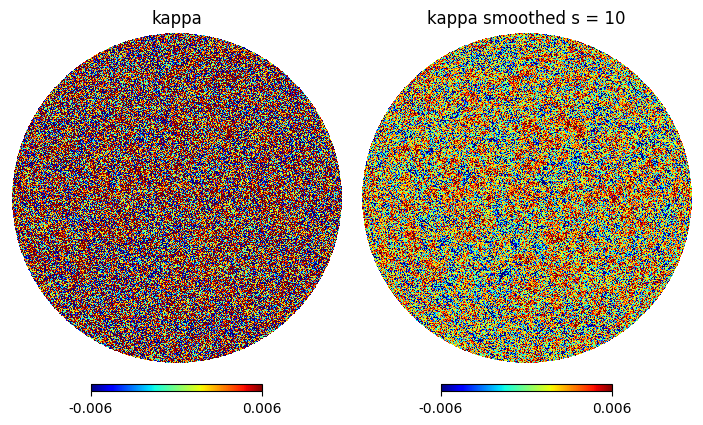

In [23]:
# plot the data
fig = plt.figure(figsize=(7, 4))
hp.orthview(kappa, title='kappa', sub=(1, 2, 1), min=-0.006, max=0.006, cmap='jet', half_sky=True)
hp.orthview(kappa_smoothed, title='kappa smoothed s = 10', sub=(1, 2, 2), min=-0.006, max=0.006, cmap='jet', half_sky=True)
plt.show()

# Flatsky

## Peaks Minima

In [24]:
center_ra = 0
center_dec = 0
patch_size_deg = 10

patch = hp.gnomview(kappa, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)
patch_smoothed = hp.gnomview(kappa_smoothed, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)
#patch_noisy = hp.gnomview(kappa_noisy, rot=[center_ra, center_dec], xsize=1024, reso=patch_size_deg*60/1024, return_projected_map=True, no_plot=True)

In [25]:
from astropy import units as u
from lenstools import ConvergenceMap

def calculate_peaks_minima(patch, angle, peak_bins, minima_bins, return_index=True):
    conv_map = ConvergenceMap(patch, angle=angle * u.deg)
    peak_height,peak_positions = conv_map.locatePeaks(peak_bins)
    peak_height,peak_positions = exclude_edges(peak_height, peak_positions, angle, patch.shape[0], return_index=return_index)

    conv_map_minus = ConvergenceMap(-patch, angle=angle * u.deg)
    minima_height,minima_positions = conv_map_minus.locatePeaks(minima_bins)
    minima_height = -minima_height

    minima_height,minima_positions = exclude_edges(minima_height, minima_positions, angle, patch.shape[0], return_index=return_index)

    print("Identified peaks: ", len(peak_positions), "Identified minima: ", len(minima_positions))

    return peak_height, peak_positions, minima_height, minima_positions

def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]

In [26]:
bins= np.linspace(-4, 4, 16, endpoint=True) 

peak_height, peak_positions, minima_height, minima_positions = calculate_peaks_minima(patch, patch_size_deg, bins * sigma, bins * sigma)
peak_height_smoothed, peak_positions_smoothed, minima_height_smoothed, minima_positions_smoothed = calculate_peaks_minima(patch_smoothed, patch_size_deg, bins * sigma_smoothed, bins * sigma_smoothed)
#peak_height_noisy, peak_positions_noisy, minima_height_noisy, minima_positions_noisy = calculate_peaks_minima(patch_noisy, patch_size_deg, peak_bins, minima_bins)

Identified peaks:  98610 Identified minima:  95758
Identified peaks:  2174 Identified minima:  2208


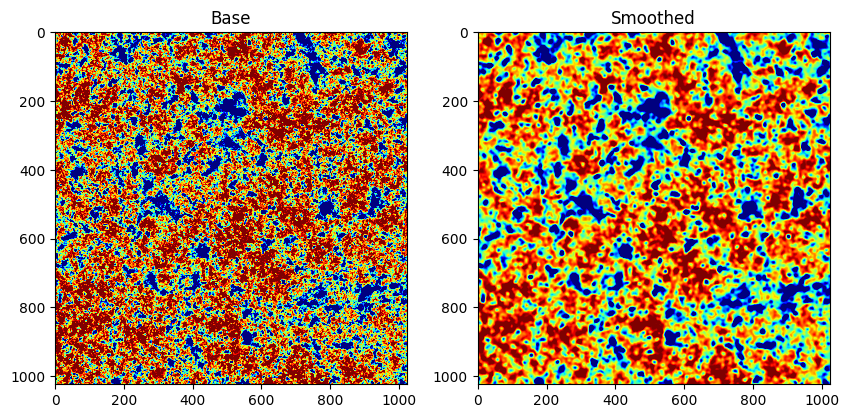

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(patch, cmap='jet', vmin=-0.006, vmax=0.006)
ax[0].set_title('Base')

ax[1].imshow(patch_smoothed, cmap='jet', vmin=-0.006, vmax=0.006)
#ax[1].scatter(peak_positions_smoothed[:, 0], peak_positions_smoothed[:, 1], facecolors='none', edgecolors='red', label='Peaks')
#ax[1].scatter(minima_positions_smoothed[:, 0], minima_positions_smoothed[:, 1], facecolors='none', edgecolors='blue', label='Minima')
ax[1].set_title('Smoothed')
plt.show()

In [30]:
import sqlite3
import healpy as hp
from astropy import units as u
from lenstools import ConvergenceMap
import numpy as np
import io
from multiprocessing import Pool, cpu_count
import argparse 

from src.utils.database_query import query_fits_paths

class WeakLensingAnalyzer:
    def __init__(self, db_path, config_sim, zs, sl, survey, lmin=300, lmax=3000, patch_size=10, xsize=1024, nbin=15):
        self.db_path = db_path
        self.config_sim = config_sim
        self.zs = zs
        self.sl = sl
        self.survey = survey
        self.lmin = lmin
        self.lmax = lmax
        self.patch_size = patch_size
        self.xsize = xsize
        self.nbin = nbin

        self.data = self._read_fits_data()
        self.stddev = np.std(self.data)

        self.l_edges = np.logspace(np.log10(self.lmin), np.log10(self.lmax), num=self.nbin + 1)
        self.kappa_edges = np.linspace(-4 * self.stddev, 4 * self.stddev, self.nbin + 1)

        self.conn = sqlite3.connect(self.db_path)
        self._setup_db()

    def _setup_db(self):
        cursor = self.conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS lensing_data (
                id INTEGER PRIMARY KEY,
                config_sim TEXT,
                zs REAL,
                sl REAL,
                survey TEXT,
                patch_id INTEGER,
                lmin INTEGER,
                lmax INTEGER,
                ell BLOB,
                cl BLOB,
                bispec_equil BLOB,
                bispec_fold BLOB,
                nu BLOB,
                pdf BLOB,
                peak_counts BLOB,
                minima_counts BLOB
            )
        ''')
        self.conn.commit()

    def _read_fits_data(self):
        file_path = query_fits_paths(config_sim=self.config_sim, zs=self.zs, sl=self.sl, survey=self.survey)[0][0]
        data = hp.read_map(file_path)
        if self.survey == 'noiseless':
            return hp.reorder(data, n2r=True)
        return data

    def _store_results(self, patches):
        cursor = self.conn.cursor()

        for i, patch in enumerate(patches):
            l, pl, bispec_equil, bispec_fold, nu, pdf, peak_counts, minima_counts = patch
            cursor.execute('''
                INSERT INTO lensing_data (config_sim, zs, sl, survey, patch_id, lmin, lmax, ell, cl, bispec_equil, bispec_fold, nu, pdf, peak_counts, minima_counts)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (self.config_sim, self.zs, self.sl, self.survey, i, self.lmin, self.lmax, self._np_to_blob(l), self._np_to_blob(pl), self._np_to_blob(bispec_equil), self._np_to_blob(bispec_fold), self._np_to_blob(nu), self._np_to_blob(pdf), self._np_to_blob(peak_counts), self._np_to_blob(minima_counts)))
        
        self.conn.commit()

    def _np_to_blob(self, array):
        out = io.BytesIO()
        np.save(out, array)
        return out.getvalue()
    
    def _blob_to_np(self, blob):
        return np.load(io.BytesIO(blob))

    def _patch_map(self, ra_dec):
        return hp.gnomview(self.data, rot=(ra_dec[0], ra_dec[1]), xsize=self.xsize, reso=self.patch_size * 60 / self.xsize, return_projected_map=True, no_plot=True)

    def _process_patch(self, patch):
        conv_map = ConvergenceMap(patch, angle=self.patch_size * u.deg)
        conv_map_minus = ConvergenceMap(-patch, angle=self.patch_size * u.deg)

        l, pl = conv_map.powerSpectrum(self.l_edges)
        _, bispec_equil = conv_map.bispectrum(l_edges=self.l_edges, configuration='equilateral')
        _, bispec_fold = conv_map.bispectrum(l_edges=self.l_edges, ratio=0.1, configuration='folded')
        nu, pdf = conv_map.pdf(self.kappa_edges)
        _, peak_counts = conv_map.peakCount(self.kappa_edges)
        _, minima_counts = conv_map_minus.peakCount(self.kappa_edges)

        return (l, pl, bispec_equil, bispec_fold, nu, pdf, peak_counts, minima_counts)

    def process_map(self):
        ra_dec_pairs = [(ra, dec) for ra in range(0, 360, self.patch_size + self.patch_size//2) for dec in range(-90 + self.patch_size + self.patch_size//2, 90, self.patch_size + self.patch_size//2)]
        self.patches = [self._process_patch(ra_dec) for ra_dec in ra_dec_pairs]
        with Pool(cpu_count()) as pool:
            patches = pool.map(self._process_patch, ra_dec_pairs)
        self._store_results(patches)

    def close(self):
        self.conn.close()

In [31]:
db_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/kappa_data.db'

In [56]:
conn = sqlite3.connect(db_path)
c = conn.cursor()
query = 'SELECT nu FROM lensing_data'
c.execute(query)
results = c.fetchall()
conn.close()

In [32]:
wla = WeakLensingAnalyzer(db_path, 'tiled', 0.5, 10, 'Euclid-LSST')

In [ ]:
def fibonacci_sphere(n, phi=1.618):
    points = []
    for i in np.arange(-n, n+1):
        theta_i = np.arcsin(2*i/(2*n+1))
        phi_i = 2 * np.pi * i / phi
        # phi_i into the range [0, 2pi]
        while phi_i < 0:
            phi_i += 2 * np.pi
        while phi_i > 2 * np.pi:
            phi_i -= 2 * np.pi
        points.append((theta_i, phi_i))
    
    points = np.array(points)
    
    # delete 10 points closest to the poles
    # sort by theta
    points = points[np.argsort(points[:, 0])]
    points = points[10:-10]

    return points

In [84]:
points = fibonacci_sphere(256)

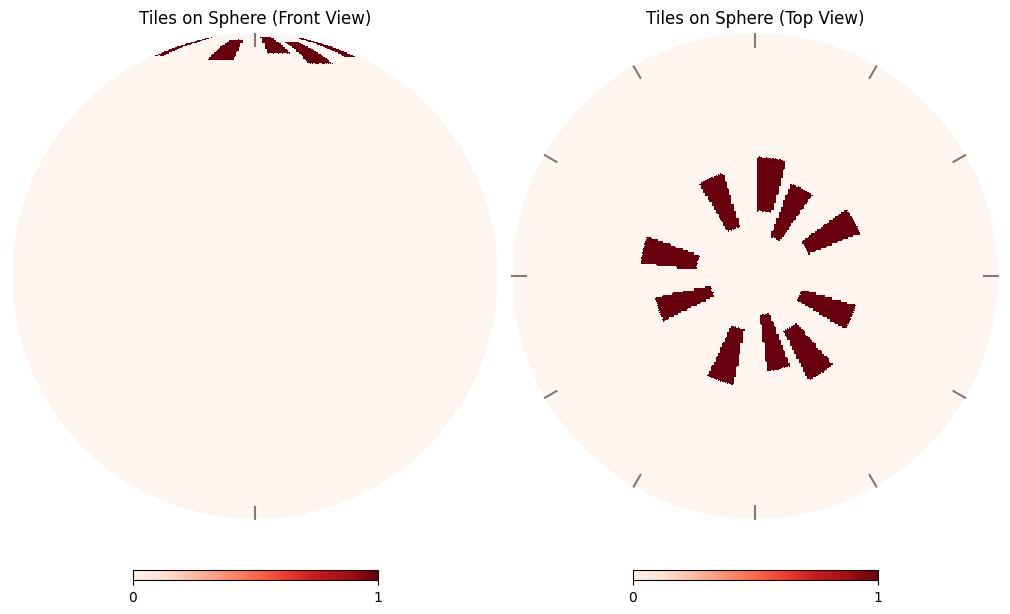

In [132]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def line_equation(x1, y1, x2, y2):
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    return A, B, C

def is_inside_rotated_rectangle(x, y, corners):
    edges = []
    for i in range(len(corners)):
        x1, y1 = corners[i]
        x2, y2 = corners[(i + 1) % len(corners)]
        edges.append(line_equation(x1, y1, x2, y2))

    for A, B, C in edges:
        if A * x + B * y + C > 0:
            return False
    return True

def create_tile_mask(nside, theta_center, phi_center, tile_size):
    diagonal = np.sqrt(2) * np.radians(tile_size) / 2

    # Get the coordinates of the corners of the tile
    corners = [
        (theta_center + diagonal, phi_center),
        (theta_center, phi_center - diagonal),
        (theta_center - diagonal, phi_center),
        (theta_center, phi_center + diagonal)
    ]

    # Create a mask for the tile
    mask = np.zeros(hp.nside2npix(nside), dtype=bool)
    for i in range(hp.nside2npix(nside)):
        theta_pixel, phi_pixel = hp.pix2ang(nside, i)
        if is_inside_rotated_rectangle(theta_pixel, phi_pixel, corners):
            mask[i] = True

    return mask

# Define the center points of the tiles
tile_centers = points[:10]

# Define the size of each tile (10x10 degrees)
tile_size = 10

# Healpy parameters
nside = 128  # Resolution of the Healpix map

# Create an empty map
map = np.zeros(hp.nside2npix(nside))


# Create masks for each tile and fill the map
for center in tile_centers:
    theta_center, phi_center = center
    theta_center = np.pi / 2 + theta_center
    mask = create_tile_mask(nside, theta_center, phi_center, tile_size)
    map[mask] = 1 

# Plot the map using orthview
fig  = plt.figure(figsize=(10,  10))
hp.orthview(map, half_sky=True, title="Tiles on Sphere (Front View)", cmap='Reds', rot=(0, 0), fig=fig, sub=(1, 2, 1))
hp.orthview(map, half_sky=True, title="Tiles on Sphere (Top View)", cmap='Reds', rot=(0, 90), fig=fig, sub=(1, 2, 2))

# Draw meridian grid
for lon in np.arange(0, 360, 30):
    lat = np.linspace(-90, 90, 100)
    theta = np.radians(90 - lat)
    phi = np.radians(lon)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    hp.projplot(theta, phi, 'k-', alpha=0.5)

plt.show()



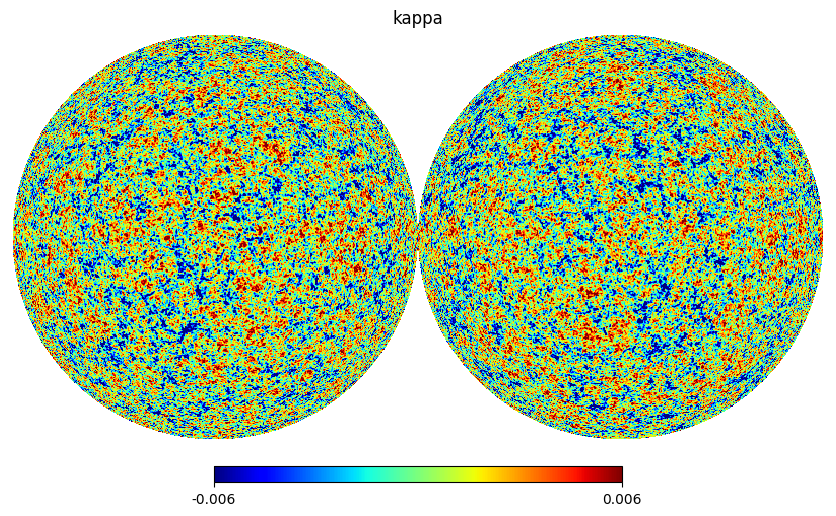

In [ ]:
hp.orthview(wla.data, title='kappa', min=-0.006, max=0.006, cmap='jet')

In [33]:
patch = wla._patch_map((0, 0))

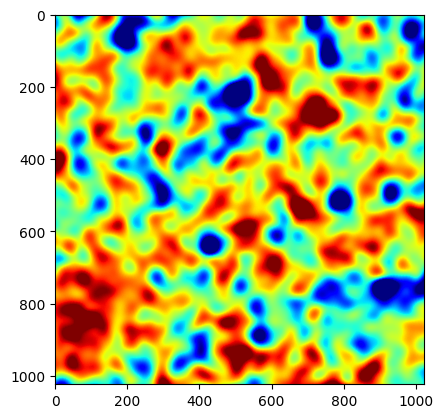

In [34]:
plt.imshow(patch, cmap='jet', vmin=-0.006, vmax=0.006)

In [35]:
l, pl, bispec_equil, bispec_fold, nu, pdf, peak_counts, minima_counts = wla._process_patch(patch)

In [36]:
np.sum(peak_counts) * (nu[1]-nu[0])

159.0

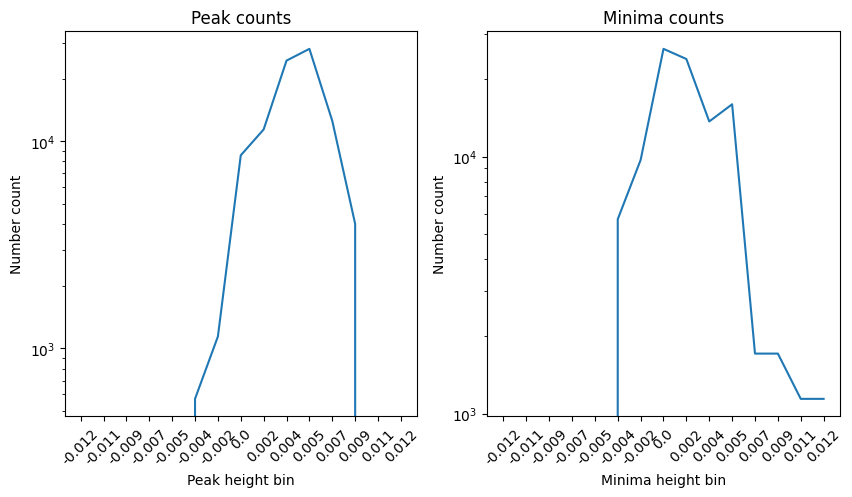

In [39]:
# plot peak counts, minima counts
# peak counts: number count in nu bin
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(peak_counts)
ax[0].set_title('Peak counts')
ax[0].set_xlabel('Peak height bin')
ax[0].set_ylabel('Number count')

# minima counts: number count in nu bin
ax[1].plot(minima_counts)
ax[1].set_title('Minima counts')
ax[1].set_xlabel('Minima height bin')
ax[1].set_ylabel('Number count')

# x-axis: xticklabels = nu
ax[0].set_xticks(np.arange(len(nu)))
ax[0].set_xticklabels(np.round(nu, 3), rotation=45)
ax[0].set_yscale('log')

ax[1].set_xticks(np.arange(len(nu)))
ax[1].set_xticklabels(np.round(nu, 3), rotation=45)
ax[1].set_yscale('log')

plt.show()
